In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv(r"C:\Users\vaibh\Desktop\DM7\Project\jan_2022_cleaned_data.csv")
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginCityName,OriginStateName,DestAirportID,Dest,DestCityName,DestStateName,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delay,DelayStatus
0,2022,1,1,14,5,2022-01-14,YX,20452,YX,N119HQ,4879,11066,CMH,"Columbus, OH",Ohio,11278,DCA,"Washington, DC",Virginia,12:24,12:21,-3.0,0.0,13:52,13:56,4.0,4.0,0.0,NaN,0.0,88.0,95,63.0,1.0,323.0,0.0,0.0,0.0,0.0,0.0,4.0,Ontime
1,2022,1,1,15,6,2022-01-15,YX,20452,YX,N122HQ,4879,11066,CMH,"Columbus, OH",Ohio,11278,DCA,"Washington, DC",Virginia,12:24,12:14,-10.0,0.0,13:52,13:28,-24.0,0.0,0.0,NaN,0.0,88.0,74,50.0,1.0,323.0,0.0,0.0,0.0,0.0,0.0,-24.0,Ontime
2,2022,1,1,16,7,2022-01-16,YX,20452,YX,N412YX,4879,11066,CMH,"Columbus, OH",Ohio,11278,DCA,"Washington, DC",Virginia,12:24,12:18,-6.0,0.0,13:52,13:39,-13.0,0.0,0.0,NaN,0.0,88.0,81,53.0,1.0,323.0,0.0,0.0,0.0,0.0,0.0,-13.0,Ontime
3,2022,1,1,17,1,2022-01-17,YX,20452,YX,N405YX,4879,11066,CMH,"Columbus, OH",Ohio,11278,DCA,"Washington, DC",Virginia,12:24,12:17,-7.0,0.0,13:52,14:01,9.0,9.0,0.0,NaN,0.0,88.0,104,56.0,1.0,323.0,0.0,0.0,0.0,0.0,0.0,9.0,Ontime
4,2022,1,1,18,2,2022-01-18,YX,20452,YX,N420YX,4879,11066,CMH,"Columbus, OH",Ohio,11278,DCA,"Washington, DC",Virginia,12:24,12:18,-6.0,0.0,13:52,13:23,-29.0,0.0,0.0,NaN,0.0,88.0,65,48.0,1.0,323.0,0.0,0.0,0.0,0.0,0.0,-29.0,Ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537897,2022,1,1,6,4,2022-01-06,DL,19790,DL,N101DQ,1576,11042,CLE,"Cleveland, OH",Ohio,10397,ATL,"Atlanta, GA",Georgia,13:55,14:13,18.0,18.0,15:46,16:02,16.0,16.0,0.0,NaN,0.0,111.0,109,94.0,1.0,554.0,0.0,0.0,0.0,0.0,16.0,16.0,Delayed
537898,2022,1,1,6,4,2022-01-06,DL,19790,DL,N883DN,1577,11433,DTW,"Detroit, MI",Michigan,13303,MIA,"Miami, FL",Florida,14:22,16:26,124.0,124.0,17:22,19:37,135.0,135.0,0.0,NaN,0.0,180.0,191,169.0,1.0,1145.0,0.0,124.0,11.0,0.0,0.0,135.0,Delayed
537899,2022,1,1,6,4,2022-01-06,DL,19790,DL,N831DN,1578,10821,BWI,"Baltimore, MD",Maryland,10397,ATL,"Atlanta, GA",Georgia,13:29,13:43,14.0,14.0,15:30,15:49,19.0,19.0,0.0,NaN,0.0,121.0,126,102.0,1.0,577.0,14.0,0.0,5.0,0.0,0.0,19.0,Delayed
537900,2022,1,1,6,4,2022-01-06,DL,19790,DL,N989AT,1579,11057,CLT,"Charlotte, NC",North Carolina,10397,ATL,"Atlanta, GA",Georgia,12:58,12:57,-1.0,0.0,14:13,14:02,-11.0,0.0,0.0,NaN,0.0,75.0,65,46.0,1.0,226.0,0.0,0.0,0.0,0.0,0.0,-11.0,Ontime


In [3]:
count_flights = df['Origin'].value_counts()


In [4]:
count_flights

ATL    25480
DFW    22637
DEN    21142
ORD    20689
CLT    16192
       ...  
ILG        9
OWB        8
PIR        3
ATY        2
PPG        2
Name: Origin, Length: 363, dtype: int64

In [5]:
airports = pd.read_csv(r"C:\Users\vaibh\Desktop\DM7\Project\airports.csv")
airports

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,GUM,Guam International,Agana,GU,USA,13.483450,-144.795983
1,PPG,Pago Pago International,Pago Pago,AS,USA,14.331023,-170.710526
2,SPN,Tinian International Airport,NaN,NaN,N Mariana Islands,14.996111,145.621384
3,STX,Henry E. Rohlsen,Christiansted,VI,USA,17.701889,-64.798556
4,PSE,Mercedita,Ponce,PR,USA,18.008303,-66.563012
...,...,...,...,...,...,...,...
312,OME,Nome,Nome,AK,USA,64.512202,-165.445246
313,FAI,Fairbanks International,Fairbanks,AK,USA,64.813677,-147.859669
314,OTZ,Ralph Wien Memorial,Kotzebue,AK,USA,66.884677,-162.598550
315,SCC,Deadhorse,Deadhorse,AK,USA,70.194756,-148.465161


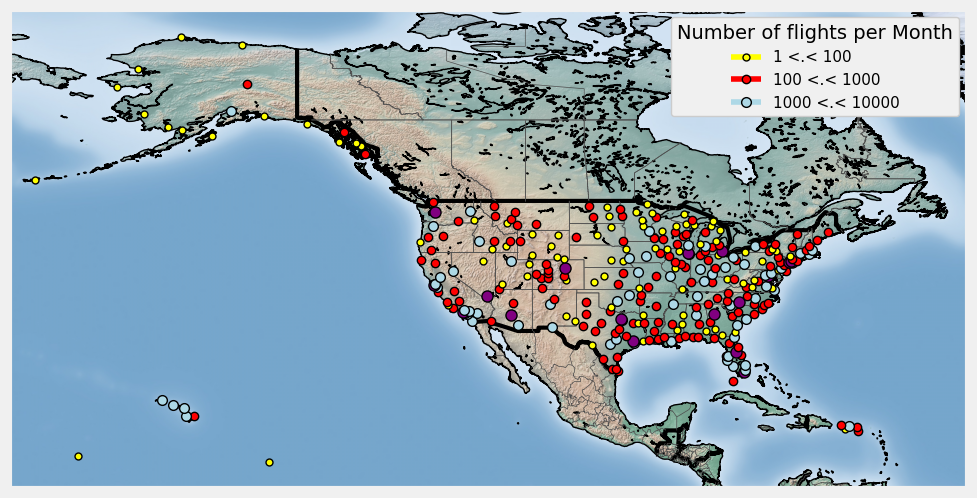

In [6]:
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])

#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 50000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label.get(key, None)
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per Month', frameon = True, framealpha = 1)
plt.show()


In [9]:
airlines = pd.read_csv(r'C:\Users\vaibh\Desktop\DM7\Project/airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,F9,Frontier Airlines Inc.
3,B6,JetBlue Airways
4,OO,Skywest Airlines Inc.
5,AS,Alaska Airlines Inc.
6,NK,Spirit Air Lines
7,WN,Southwest Airlines Co.
8,DL,Delta Air Lines Inc.
9,HA,Hawaiian Airlines Inc.


In [10]:
abbr = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'HA': 'Hawaiian Airlines',
 'MQ': 'Envoy Air',
 'QX': 'Horizon Air',
 'G4': 'Allegiant Air',
 'YV': 'Mesa Airlines',
 'OH': 'PSA Airlines',
 'YX': 'Republic Airways',
 '9E': 'Endeavor Air'}

In [11]:
temp = pd.read_csv(r"C:\Users\vaibh\Desktop\DM7\Project\airports.csv")
identify_airport = temp.set_index('IATA')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA')['LONGITUDE'].to_dict()

In [12]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['Reporting_Airline'] == carrier]
    count_trajectories = df2.groupby(['Origin', 'Dest']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr[carrier]))
    

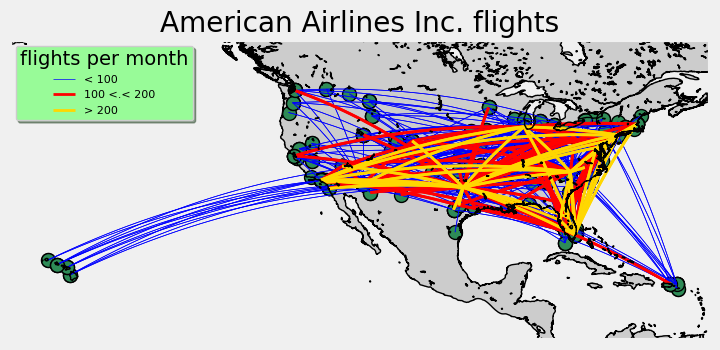

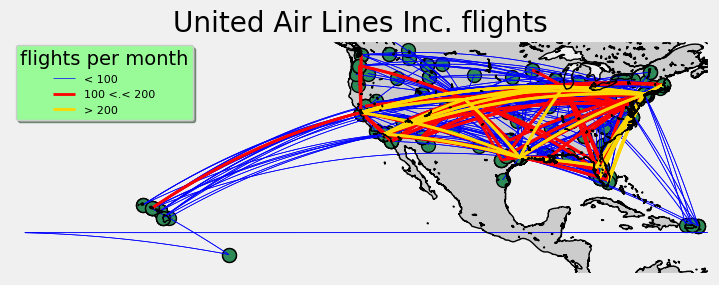

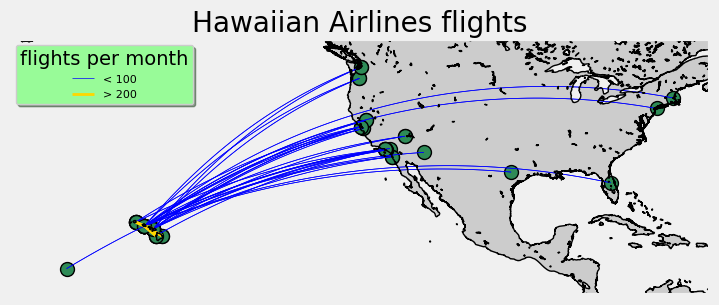

In [13]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['UA'] = [-182, -63, 10, 50]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA','UA','HA']: 
    make_map(df, carrier, *coord[carrier])